In [28]:
# from geoband.API import *

import folium
from folium import plugins
import json
# import geopandas as gpd

import pandas as pd
import numpy as np

import json

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [29]:
# 한글깨짐 방지코드
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# # 데이터를 서버 주피터 노트북에 다운
# GetCompasData('SBJ_2012_001', '8', '8.오산시_유동인구(2019).csv')
# GetCompasData('SBJ_2012_001', '9', '9.오산시_어린이보호구역.csv')
# GetCompasData('SBJ_2012_001', '31', '31.오산시_법정경계(시군구).geojson')
# GetCompasData('SBJ_2012_001', '33', '33.오산시_법정경계(읍면동).geojson')

In [4]:
ppl=pd.read_csv("8.오산시_유동인구(2019).csv")
print(ppl.shape)
ppl.head()

(125163, 27)


STD_YM         lon        lat  TMST_00  TMST_01  TMST_02  TMST_03  TMST_04  \
0  201901  126.995145  37.176703     0.08     0.05     0.04     0.04     0.08   
1  201901  126.995142  37.177153     0.06     0.04     0.03     0.03     0.06   
2  201901  126.995714  37.175804     0.00     0.00     0.00     0.00     0.00   
3  201901  126.995711  37.176254     0.05     0.03     0.02     0.03     0.05   
4  201901  126.995708  37.176705     0.02     0.01     0.01     0.01     0.02   

   TMST_05  TMST_06  ...  TMST_14  TMST_15  TMST_16  TMST_17  TMST_18  \
0     0.27     0.80  ...     0.69     0.76     0.95     0.91     0.70   
1     0.19     0.56  ...     0.54     0.58     0.69     0.66     0.51   
2     0.01     0.03  ...     0.04     0.04     0.05     0.05     0.03   
3     0.19     0.56  ...     0.48     0.53     0.65     0.63     0.48   
4     0.07     0.18  ...     0.19     0.20     0.23     0.22     0.17   

   TMST_19  TMST_20  TMST_21  TMST_22  TMST_23  
0     0.43     0.34     0.22     0.14     0.10  
1     0.33     0.26     0.17     0.11     0.08  
2     0.02     0.02     0.01     0.01     0.00  
3     0.29     0.23     0.15     0.10     0.07  
4     0.11     0.09     0.06     0.04     0.03  

[5 rows x 27 columns]

# 평균 유동인구과 어린이보호구역에 대해 탐색해보자.

In [5]:
ppl2=ppl.groupby(['lon','lat']).mean().reset_index().drop('STD_YM', axis=1)
ppl2=pd.melt(ppl2, id_vars=['lon','lat'])
ppl2=ppl2.groupby(['lon','lat']).mean().reset_index()

mms = MinMaxScaler()
ppl2['value'] = mms.fit_transform(np.array(ppl2['value']).reshape(-1,1))

ppl2

lon        lat     value
0      126.995142  37.177153  0.004276
1      126.995145  37.176703  0.006964
2      126.995148  37.176252  0.001719
3      126.995151  37.175801  0.001137
4      126.995154  37.175351  0.001063
...           ...        ...       ...
12397  127.097793  37.150955  0.000409
12398  127.097819  37.145997  0.003287
12399  127.098354  37.151407  0.002906
12400  127.098356  37.150956  0.025965
12401  127.100634  37.146006  0.000301

[12402 rows x 3 columns]

In [6]:
ppl2['value'].min()

0.0

In [7]:
ppl_location = []

for i in range(len(ppl2)):
    temp = []
    temp.append(ppl2.loc[i, 'lat'])
    temp.append(ppl2.loc[i, 'lon'])
    temp.append(ppl2.loc[i, 'value'])
    ppl_location.append(temp)

In [8]:
print('전체 리스트 개수:', len(ppl_location))
print('첫번째 리스트 안의 데이터 개수:', len(ppl_location[0]))

전체 리스트 개수: 12402
첫번째 리스트 안의 데이터 개수: 3


In [9]:
# ssg=gpd.read_file('31.오산시_법정경계(시군구).geojson')
# emd=gpd.read_file('33.오산시_법정경계(읍면동).geojson')

In [42]:
zone=pd.read_csv("data/9.오산시_어린이보호구역.csv")
print(zone.shape)
zone.head()

(91, 7)


시설종류     시설명 CCTV설치여부  CCTV설치대수  보호구역도로폭     보호구역_경도    보호구역_위도
0  특수학교    성심학교        N         0       25  127.017521  37.176762
1  초등학교  가수초등학교        Y         1       12  127.047957  37.148103
2  초등학교  광성초등학교        Y         2       12  127.039709  37.184197
3  초등학교  대호초등학교        Y         3       12  127.057889  37.159106
4  초등학교  매홀초등학교        Y         2        6  127.063282  37.162749

In [43]:
zone_cmap={'어린이집':'orange', 
           '초등학교':'green', 
           '유치원':'blue', 
           '특수학교':'red'}
zone['marker_color']=zone['시설종류'].map(zone_cmap)

In [14]:
# 오산시 중심 맵 생성
center = [37.14887, 127.07728]
m = folium.Map(location=center, zoom_start=13)

hm = plugins.HeatMap(ppl_location, 
                     min_opacity=0.1,
                     max_val=1,
                     radius=10, blur=15,
                     max_zoom=5, color='red'
                    )

hm.add_to(m)

# folium.GeoJson(emd).add_to(m)


# 어린이보호구역 시각화
for i in range(len(zone)):
    folium.Marker(
    location = zone.loc[i, ['보호구역_위도', '보호구역_경도']],
    popup = zone.loc[i, '시설명'],
    radius = 15,
    icon=folium.Icon(color=zone.loc[i, 'marker_color'], icon='child', prefix='fa')
    ).add_to(m)

m

In [64]:
# m.save('어린이보호구역+평균유동인구.html')

# 시간대별 유동인구과 어린이보호구역에 대해 탐색해보자.

In [15]:
# 시간대별 유동인구과 어린이보호구역에 대해 탐색해보자.
ppl3=ppl.groupby(['lon', 'lat']).mean()
ppl3=ppl3.drop('STD_YM', axis=1).reset_index()
ppl3=pd.melt(ppl3, id_vars=['lon', 'lat'], var_name='timestamp')
ppl3

lon        lat timestamp     value
0       126.995142  37.177153   TMST_00  0.061250
1       126.995145  37.176703   TMST_00  0.093333
2       126.995148  37.176252   TMST_00  0.017143
3       126.995151  37.175801   TMST_00  0.020000
4       126.995154  37.175351   TMST_00  0.020000
...            ...        ...       ...       ...
297643  127.097793  37.150955   TMST_23  0.033333
297644  127.097819  37.145997   TMST_23  0.270000
297645  127.098354  37.151407   TMST_23  0.206667
297646  127.098356  37.150956   TMST_23  1.870000
297647  127.100634  37.146006   TMST_23  0.017500

[297648 rows x 4 columns]

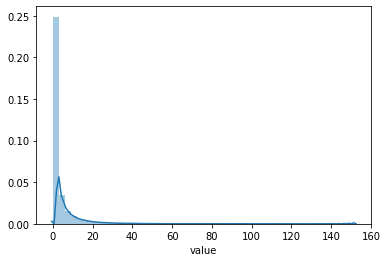

In [16]:
sns.distplot(ppl3['value'])

In [17]:
ppl3['value'].describe()

count    297648.000000
mean          3.064252
std           6.641320
min           0.000000
25%           0.107500
50%           0.640000
75%           2.923333
max         151.940000
Name: value, dtype: float64

In [69]:
ppl4=ppl3[ppl3['value']>0.64].reset_index(drop=True)
mms=MinMaxScaler()
ppl4['value_mms']=mms.fit_transform(np.array(ppl4['value']).reshape(-1,1))

ppl4

lon        lat timestamp     value  value_mms
0       126.996820  37.178963   TMST_00  3.210000   0.016986
1       126.997395  37.177163   TMST_00  0.695000   0.000364
2       126.997952  37.178067   TMST_00  0.663333   0.000154
3       126.998524  37.176717   TMST_00  0.712500   0.000479
4       126.999088  37.176719   TMST_00  0.709167   0.000457
...            ...        ...       ...       ...        ...
148790  127.095526  37.153651   TMST_23  1.062857   0.002795
148791  127.095536  37.151848   TMST_23  1.904167   0.008355
148792  127.096087  37.154104   TMST_23  1.519167   0.005811
148793  127.097228  37.151403   TMST_23  3.308000   0.017634
148794  127.098356  37.150956   TMST_23  1.870000   0.008130

[148795 rows x 5 columns]

In [19]:
time_list=ppl3['timestamp'].unique()
print(time_list)

['TMST_00' 'TMST_01' 'TMST_02' 'TMST_03' 'TMST_04' 'TMST_05' 'TMST_06'
 'TMST_07' 'TMST_08' 'TMST_09' 'TMST_10' 'TMST_11' 'TMST_12' 'TMST_13'
 'TMST_14' 'TMST_15' 'TMST_16' 'TMST_17' 'TMST_18' 'TMST_19' 'TMST_20'
 'TMST_21' 'TMST_22' 'TMST_23']


In [70]:
info=[]

for t in time_list:
    a=[]
    temp=ppl4[ppl4['timestamp']==t]
    
    for lat, lon, value in zip(temp['lat'], temp['lon'], temp['value_mms']):
        a.append([lat, lon, value])
    
    info.append(a)

In [71]:
print('전체 리스트 개수:', len(info))
print('첫번째 리스트 안의 데이터 개수:', len(info[0]))

전체 리스트 개수: 24
첫번째 리스트 안의 데이터 개수: 4460


In [22]:
info

[[[37.178963214102, 126.99681976568, 0.016986120290812947],
  [37.1771628425557, 126.99739495898301, 0.0003635161929940525],
  [37.178066611525395, 126.997952230816, 0.00015421899096717314],
  [37.176716924692705, 126.998524411359, 0.00047918043621943216],
  [37.1767193070556, 126.999087644814, 0.00045714915179554793],
  [37.176268616284794, 126.999090620375, 0.00018175809649702453],
  [37.1731374532369, 127.004743518016, 0.0012062128222075355],
  [37.172686761805295, 127.004746459599, 0.0017129323639568173],
  [37.1726891143766, 127.00530966367201, 0.006097157964309318],
  [37.173142155779296, 127.00586993291799, 0.0030953954615554075],
  [37.172691464271296, 127.005872867811, 0.007661379158404935],
  [37.172240772728706, 127.00587580263901, 0.004059264155100239],
  [37.1713393895399, 127.00588167209801, 0.0026107072042300065],
  [37.174045886024, 127.006427277174, 0.001029962546816479],
  [37.173144503035395, 127.006433140467, 0.007237276933245207],
  [37.172693811489296, 127.0064360

In [72]:
# base map
m = folium.Map([37.14887, 127.07728], zoom_start=13)

# 시군구
# folium.GeoJson(ssg).add_to(m)

# 어린이보호구역
for i in range(len(zone)):
    folium.Circle(
    location = zone.loc[i, ['보호구역_위도', '보호구역_경도']],
    radius=30
    ).add_to(m)

# heatmap with time
hm = plugins.HeatMapWithTime(info, index=[str(i) for i in range(0,24)], auto_play=True)
hm.add_to(m)


m.save('어린이보호구역+유동인구-시간대별.html')

# 어린이보호구역에 대해 탐색해보자.

In [25]:
zone.head(10)

시설종류     시설명 CCTV설치여부  CCTV설치대수  보호구역도로폭     보호구역_경도    보호구역_위도  \
0  특수학교    성심학교        N         0       25  127.017521  37.176762   
1  초등학교  가수초등학교        Y         1       12  127.047957  37.148103   
2  초등학교  광성초등학교        Y         2       12  127.039709  37.184197   
3  초등학교  대호초등학교        Y         3       12  127.057889  37.159106   
4  초등학교  매홀초등학교        Y         2        6  127.063282  37.162749   
5  초등학교  삼미초등학교        Y         2        6  127.060269  37.191356   
6  초등학교  성산초등학교        Y         3       12  127.067040  37.150444   
7  초등학교  성호초등학교        Y         2       12  127.070953  37.150478   
8  초등학교  수청초등학교        Y         3       18  127.055474  37.170857   
9  초등학교  오산초등학교        Y         3        6  127.050165  37.145158   

  marker_color  
0          red  
1        green  
2        green  
3        green  
4        green  
5        green  
6        green  
7        green  
8        green  
9        green

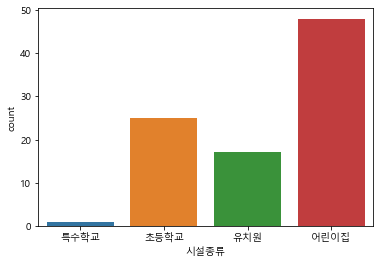

In [31]:
# 어린이 보호구역 시설 종류
sns.countplot(zone['시설종류'])
plt.show()

In [57]:
# 어린이보호구역 중 CCTV 설치가 되어있는 시설 개수
zone_CCTV_yes=zone[zone['CCTV설치여부']=='Y']
zone_CCTV_yes.groupby('시설종류')['CCTV설치여부'].count()

시설종류
어린이집    35
유치원     15
초등학교    24
Name: CCTV설치여부, dtype: int64

In [58]:
# 어린이보호구역 중 CCTV 설치가 되어있는 시설의 CCTV 설치 대수
zone_CCTV_yes.groupby('시설종류')['CCTV설치대수'].sum()

# => 시설 개수 대비 초등학교가 CCTV설치가 많이 되어있음

시설종류
어린이집    37
유치원     16
초등학교    51
Name: CCTV설치대수, dtype: int64

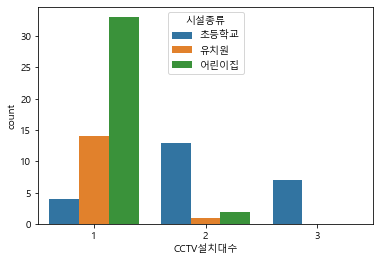

In [80]:
# 어린이보호구역 중 CCTV 설치가 되어있는 시설의 CCTV설치대수
sns.countplot(zone_CCTV_yes['CCTV설치대수'], hue=zone_CCTV_yes['시설종류'])

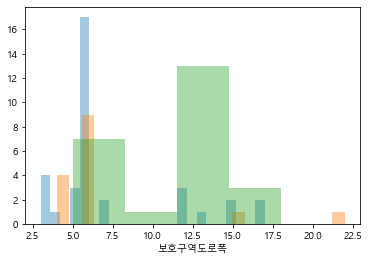

In [86]:
# 어린이보호구역 중 CCTV 설치가 되어있는 시설의 보호구역도로폭
sns.distplot(zone_CCTV_yes[zone_CCTV_yes['시설종류']=='어린이집']['보호구역도로폭'], kde=False)
sns.distplot(zone_CCTV_yes[zone_CCTV_yes['시설종류']=='유치원']['보호구역도로폭'], kde=False)
sns.distplot(zone_CCTV_yes[zone_CCTV_yes['시설종류']=='초등학교']['보호구역도로폭'], kde=False)

plt.show()

In [91]:
# 어린이보호구역 중 CCTV 설치가 안 되어있는 시설 개수
zone_CCTV_no=zone[zone['CCTV설치여부']=='N']
zone_CCTV_no.groupby('시설종류')['CCTV설치여부'].count()

시설종류
어린이집    13
유치원      2
초등학교     1
특수학교     1
Name: CCTV설치여부, dtype: int64

In [92]:
# 어린이보호구역 중 CCTV 설치가 안 되어있는 시설의 CCTV 설치 대수
zone_CCTV_no.groupby('시설종류')['CCTV설치대수'].sum()

# => 초등학교 1개가 cctv가 있네??

시설종류
어린이집    0
유치원     0
초등학교    1
특수학교    0
Name: CCTV설치대수, dtype: int64

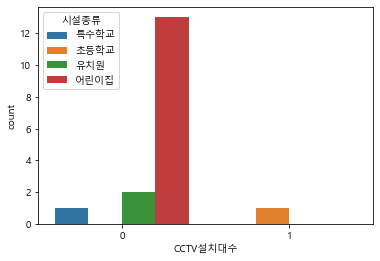

In [93]:
# 어린이보호구역 중 CCTV 설치가 되어있는 시설의 CCTV설치대수
sns.countplot(zone_CCTV_no['CCTV설치대수'], hue=zone_CCTV_no['시설종류'])

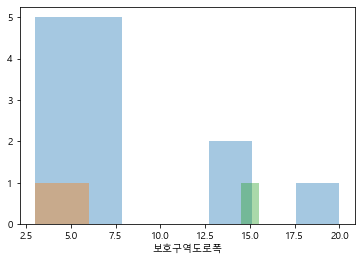

In [94]:
# 어린이보호구역 중 CCTV 설치가 되어있는 시설의 보호구역도로폭
sns.distplot(zone_CCTV_no[zone_CCTV_no['시설종류']=='어린이집']['보호구역도로폭'], kde=False)
sns.distplot(zone_CCTV_no[zone_CCTV_no['시설종류']=='유치원']['보호구역도로폭'], kde=False)
sns.distplot(zone_CCTV_no[zone_CCTV_no['시설종류']=='초등학교']['보호구역도로폭'], kde=False)

plt.show()